In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [62]:
df= pd.read_csv('Datasets/Spiral.csv', names= ['v1','v2','labels'])
display(df)

,v1,v2,labels
0,31.95,7.95,3
1,31.15,7.30,3
2,30.45,6.65,3
3,29.70,6.00,3
4,28.90,5.55,3
...,...,...,...
307,15.75,13.85,2
308,15.65,14.05,2
309,15.65,14.25,2
310,15.65,14.50,2


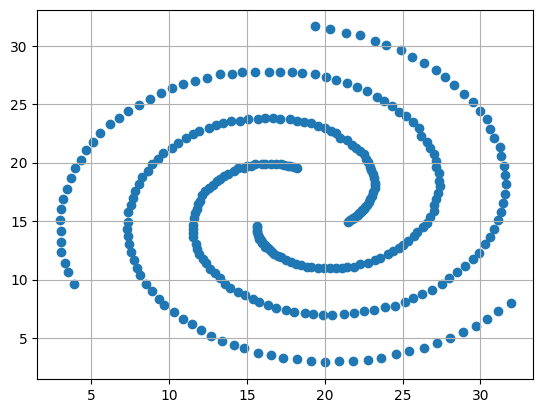

In [63]:
plt.scatter(df.values[:,0],df.values[:,1])
plt.grid()
plt.show()

In [66]:
labels= df['labels'].values
#display(labels)
distance_matrix= df.copy().drop(df['labels'])
sigma= 1
similarity_matrix= np.exp(-(euclidean_distances(distance_matrix)**2)/(2*sigma**2))
display(similarity_matrix)

array([[1.00000000e+00, 5.36067753e-04, 6.41898855e-06, ...,
        2.95412125e-67, 5.92710752e-68, 3.06343343e-68],
       [5.36067753e-04, 1.00000000e+00, 5.98996215e-01, ...,
        1.67519590e-55, 1.84460508e-56, 7.49960461e-57],
       [6.41898855e-06, 5.98996215e-01, 1.00000000e+00, ...,
        6.52577636e-53, 6.26259742e-54, 2.40992354e-54],
       ...,
       [2.95412125e-67, 1.67519590e-55, 6.52577636e-53, ...,
        1.00000000e+00, 9.69233234e-01, 9.40588063e-01],
       [5.92710752e-68, 1.84460508e-56, 6.26259742e-54, ...,
        9.69233234e-01, 1.00000000e+00, 9.95012479e-01],
       [3.06343343e-68, 7.49960461e-57, 2.40992354e-54, ...,
        9.40588063e-01, 9.95012479e-01, 1.00000000e+00]])

In [68]:
k= 10
for i,row in enumerate(similarity_matrix):
    sorted_similarity_indexes= np.argsort(row)[::-1][:k]            #Per ogni riga prendo i k indici corrispondenti alla maggiore similarità(similarità ordinata in ordine crescente)
    for j in range(row.size):
        if j not in sorted_similarity_indexes:
            similarity_matrix[i,j]= 0 if i not in np.argsort(similarity_matrix[j])[::-1][:k] else similarity_matrix[i,j] #Similarità per addizione

m_similarity= similarity_matrix.copy()
m_similarity.shape

(309, 309)

In [69]:
weight_matrix= m_similarity - np.eye(m_similarity.shape[0]) #La matrice dei pesi è la matrice della similarità senza la diagionale (che corrisponde a 1 perchè max similarità)

In [70]:
degree_matrix= np.diag([np.sum(weight_matrix[i,:]) for i in range(weight_matrix.shape[0])]) #La degree matrix è un amatrice diagonale con el. diag. somma dei pesi lungo la riga

In [71]:
elle= degree_matrix - weight_matrix

W= csr_matrix(weight_matrix)
D= csr_matrix(degree_matrix)
L= D -W

In [72]:
def power_method(A, mu = 0, tol = 1e-8, max_iter = 1000):
    """
    Inverse power method applied to the matrix A shifted by a factor mu*I. 
    Returns the smallest eigenvalue of A and the associated eigenvector
    """
    print(A.shape)
    n = A.shape[0]
    v = np.random.rand(n, 1)
    v = v / np.linalg.norm(v)
    I = np.eye(n)
    
    for k in range(max_iter):
        #Solve (A - mu * I) * v_new = v_old
        y = (A - mu * I) @ v
        v_new = y / np.linalg.norm(y)
        lambda_k = (v_new.T @ A @ v_new).item()                             #copy an element of an array in standard python scalar and return it
        v_new =v_new.reshape((n,1))
        if np.linalg.norm(A @ v_new - lambda_k * v_new) < tol:
            return lambda_k, v_new
            break
        else:
            v = v_new

In [73]:
def inverse_power_method(A, mu, tol = 1e-8, max_iter = 1000):
    """
    Inverse power method applied to the matrix A shifted by a factor mu*I. 
    Returns the smallest eigenvalue of A and the associated eigenvector
    """

    n = A.shape[0]
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    I = np.eye(n)
    
    for k in range(max_iter):
        y = np.linalg.solve(A - mu * I, v)                          #Solve (A - mu * I) * v_new = v_old
        v_new = y / np.linalg.norm(y)
        lambda_k = (v_new.T @ A @ v_new).item()
        if np.linalg.norm(A @ v_new - lambda_k * v_new) < tol:      #We accept just a treshold of equality, due to numerical cancellation
            return lambda_k, v
        v = v_new

try:
    inverse_eigenvalues,_= inverse_power_method(L, mu=0)
except np.linalg.LinAlgError:
    inverse_eigenvalues,_= inverse_power_method(L, mu=1e-6)

In [74]:
def shifting_small_method(A, M, tol = 1e-8):
    """
    Shifting method applied to the symmetric matrix A in order to find the smallest M eigenvalues and 
    corresponding eigenvectors of A.
    A: symmetric matrix for which we want to return the eigenvalues
    M: number of small eigenvalues to compute
    tol: tolerance of the inverse power method
    Returns the M smallest eigenvalues and the corresponding eigenvectors.
    """
    eigenvalues = []
    eigenvectors = []
    A_current = A.copy()
    n = A.shape[0]
    """
    try:
        gamma, _ = power_method(A_current, 0, tol, max_iter = 1000)
    except np.linalg.LinAlgError:
        mu = 1e-6
        gamma, _ = power_method(A_current, mu, tol, max_iter = 1000)
    """
    
    #gamma = 10 * M/n * gamma
    gamma = 100
    if M > n:
        raise np.linalg.LinAlgError(f"{n}-squared cannot have {M} eigenvalues")

    for i in range(M):
        try:
            #first try to apply inverse power method without shifting the matrix A (mu = 0)
            eigenvalue_i, eigenvector_i = inverse_power_method(A_current, 0, tol, max_iter = 1000) 
        except np.linalg.LinAlgError:
            #if LinAlgError occurs (singular matrix, eigenvalue equal to 0), then matrix A is shifted by a small quantity mu to allow the computation
            mu = 1e-6
            eigenvalue_i, eigenvector_i = inverse_power_method(A_current, mu, tol, max_iter = 1000) 
        eigenvalues.append(eigenvalue_i)
        eigenvectors.append(eigenvector_i)
        #delete the contribute along the rank 1 matrix eigenvector_i*eigenvector_i.T
        A_current = A_current  - eigenvalue_i * np.outer(eigenvector_i, eigenvector_i) #it could be a problem for the conditioning number of the next iterations (no prob if i compute the maximum eigenvalue)
        A_current = A_current  + gamma * np.outer(eigenvector_i, eigenvector_i)
    return np.array(eigenvalues), np.array(eigenvectors).T

In [86]:
eig_eigenvalues, eig_eigenvectors= np.linalg.eig(elle)
eigenvalues,eigenvectors= shifting_small_method(L,10)

print(np.allclose(eig_eigenvectors[:,np.argsort(eig_eigenvalues)[:10]],np.array(eigenvectors),atol= 0.5))   #0.5??
print()
print(eig_eigenvalues[np.argsort(eig_eigenvalues)[:10]])
print(eigenvalues)                                              #ok


True

[2.76448172e-15 1.96031943e-05 6.81816920e-05 5.77958941e-04
 4.02367593e-03 4.39923491e-03 4.85011200e-03 1.81388052e-02
 1.85258190e-02 1.99039668e-02]
[-1.79361534e-17  1.95905555e-05  6.81700942e-05  5.77944522e-04
  4.02077864e-03  4.39839213e-03  4.85008451e-03  1.81355891e-02
  1.85257296e-02  1.99030498e-02]


In [87]:
def deflation_inverse_power_method(A,M=4,mu=0,tol=1e-8,max_iter=1000, compute_eigenvectors= 'off'):
    n= A.shape[0]
    e1= np.zeros(n).T
    e1[0]= 1
    Actual_A= A.copy()
    E= np.zeros((n,n))
    B_prec= np.zeros((n,n))
    P_prec= np.zeros((n,n))
    Actual_vector= np.zeros((1,n))
    eigenvalues= []
    eigenvectors= []
    if compute_eigenvectors == 'off':
        P= np.zeros((n,n))
        eigenvalues= []
        for i in range(M):
            min_lamda_i, x_i = inverse_power_method(Actual_A,mu)
            eigenvalues.append(min_lamda_i)
            P_bar_i= np.eye(n-i) - 2* (np.outer(x_i + e1[:n-i],x_i + e1[:n-i])/(np.linalg.norm(x_i + e1[:n-i])**2))
            B_bar_i= P_bar_i @ Actual_A @ P_bar_i
            Actual_A= B_bar_i[1:,1:]
            P[i,i]= min_lamda_i
        return eigenvalues
    else:
        for i in range(M):
            if i == 0:
                try:
                    min_eigenvalue_i, x_i= inverse_power_method(A, mu=0)
                except np.linalg.LinAlgError:
                    min_eigenvalue_i, x_i= inverse_power_method(A, mu=1e-6)
                eigenvalues.append(min_eigenvalue_i)
                eigenvectors.append(x_i)
                Actual_vector = x_i
                P_bar_i= np.eye(n-i) - 2* (np.outer(x_i + e1[:n-i],x_i + e1[:n-i])/(np.linalg.norm(x_i + e1[:n-i])**2))
                B_bar_i= P_bar_i @ Actual_A @ P_bar_i
                Actual_A= B_bar_i[1:,1:]
                E[i,i]= min_eigenvalue_i
                P_prec = P_bar_i
                B_prec = B_bar_i
            else:
                E[i,i]= min_eigenvalue_i
                P_bar_i= np.eye(n-i) - 2* (np.outer(x_i + e1[:n-i],x_i + e1[:n-i])/(np.linalg.norm(x_i + e1[:n-i])**2))
                B_bar_i= P_bar_i @ Actual_A @ P_bar_i
                Actual_A= B_bar_i[1:,1:]
                try:
                    min_eigenvalue_i,_= inverse_power_method(Actual_A,mu=0)
                except np.linalg.LinAlgError:
                    min_eigenvalue_i,_= inverse_power_method(Actual_A, mu=1e-6)
                eigenvalues.append(min_eigenvalue_i)
                P_i= np.zeros((n,n))
                for k in range(0,i):
                    P_i[k,k]= 1
                P_i[i+1:,i+1:]= P_bar_i
                B_i= P_i @ B_prec @ P_i
                first_parameter= B_prec[i-1,i:]*Actual_vector/(eigenvalues[i-1]-min_eigenvalue_i)
                new_vector= np.zeros((1,n-i-1))
                new_vector[0]= first_parameter
                new_vector[1:]= Actual_vector
                Actual_A= new_vector
                for j in range(0,i-1,-1):
                    parameter= B_prec[j,j:]*Actual_A/(eigenvalues[j-1]-min_eigenvalue_i)
                    new_vector= np.zeros((1,j-1))
                    new_vector[0]= parameter
                    new_vector[1:]= Actual_vector
                    Actual_vector= new_vector
                eigenvectors.append(Actual_vector)
        return eigenvalues,eigenvectors

In [89]:
eigenvalues_defl= deflation_inverse_power_method(L,10)

[3.492879438210919e-17, 1.9548930849871403e-05, 6.814146308497279e-05, 0.0005773965924835984, 0.004023646919016156, 0.004371441477445271, 0.004850088732148909, 0.018129331997721886, 0.018509596408928408, 0.019898725791769854]


In [90]:
def create_L(X, k):
    distance_matrix = euclidean_distances(X)
    similarity_matrix = np.exp(-distance_matrix**2/(2*sigma**2))
    for i, row in enumerate(similarity_matrix):
        ndx_max  = np.argsort(row)[::-1][:k]
        for j in range(row.size):
            if j not in ndx_max:
                similarity_matrix[i, j] = 0 if i not in np.argsort(similarity_matrix[j])[::-1][:k] else similarity_matrix[i, j]
    weight  = similarity_matrix - np.identity(X.shape[0])
    degree_matrix = np.diag(weight.sum(axis = 1))
    return degree_matrix - weight 

In [92]:
L10 = create_L(df.values, 10)
L20 = create_L(df.values, 20)
L40 = create_L(df.values, 40)

L10 = csr_matrix(L10)
L20 = csr_matrix(L20)
L40 = csr_matrix(L40)

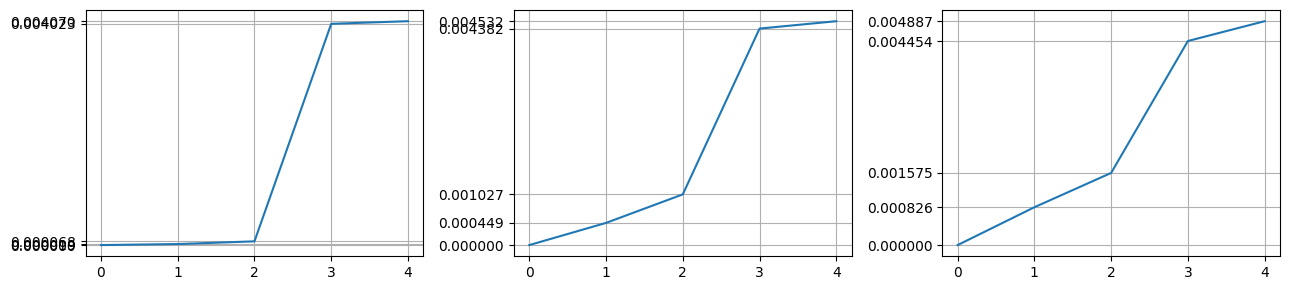

In [102]:
matries_L = [L10, L20, L40]  
fig, ax = plt.subplots(1, 3, figsize = (13,3))
for i,matrix in enumerate(matries_L):
    L_eigenval = deflation_inverse_power_method(matrix ,5)
    ax[i].plot(np.arange(len(L_eigenval)), L_eigenval)
    ax[i].set_yticks(L_eigenval)
    ax[i].grid()
plt.tight_layout()
plt.show()

k= 10 --> M=3
k= 20 --> M=3
k= 40 --> M=3

In [104]:
L10_eigenval, L10_eigenvec = shifting_small_method(L10, 3) #shifting with k = 10 for finding 4 clusters
L20_eigenval, L20_eigenvec = shifting_small_method(L20, 3)
L40_eigenval, L40_eigenvec = shifting_small_method(L40, 3)

U10 = np.array(L10_eigenvec)
U20 = np.array(L20_eigenvec)
U40 = np.array(L40_eigenvec)

In [105]:
elle10= create_L(df.values,10)  #Test
elle20= create_L(df.values,20)  #Test
elle40= create_L(df.values,40)  #Test

np_eigenval_L10, np_eigenvec_L10 = np.linalg.eig(elle10)    #Test
np_eigenval_L20, np_eigenvec_L20 = np.linalg.eig(elle20)    #Test
np_eigenval_L40, np_eigenvec_L40= np.linalg.eig(elle40)     #Test

testU10= np_eigenvec_L10[:, np.argsort(np_eigenval_L10)[:3]]
testU20= np_eigenvec_L20[:, np.argsort(np_eigenval_L20)[:3]]
testU40= np_eigenvec_L40[:, np.argsort(np_eigenval_L40)[:3]]

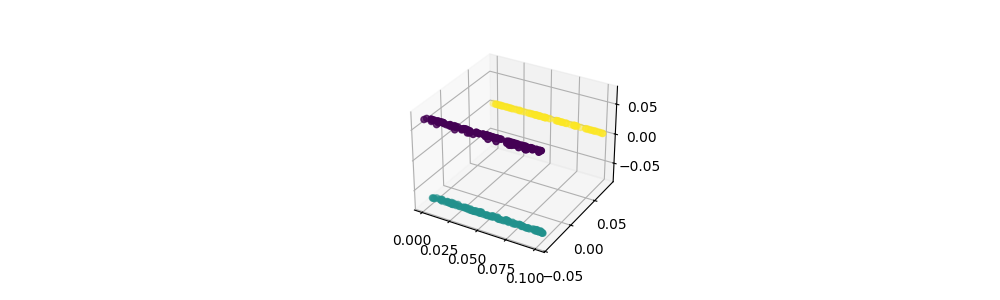

In [132]:
#Shift Method
%matplotlib widget
y10 = U10
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y10[:, 0], y10[:, 1], y10[:, 2], c= labels)
ax.grid()
plt.show()

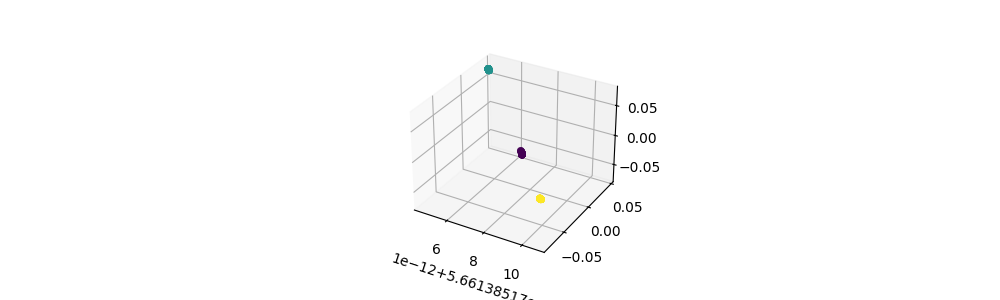

In [133]:
#eig Method
%matplotlib widget
y10 = testU10
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y10[:, 0], y10[:, 1], y10[:, 2], c= labels)
ax.grid()
plt.show()

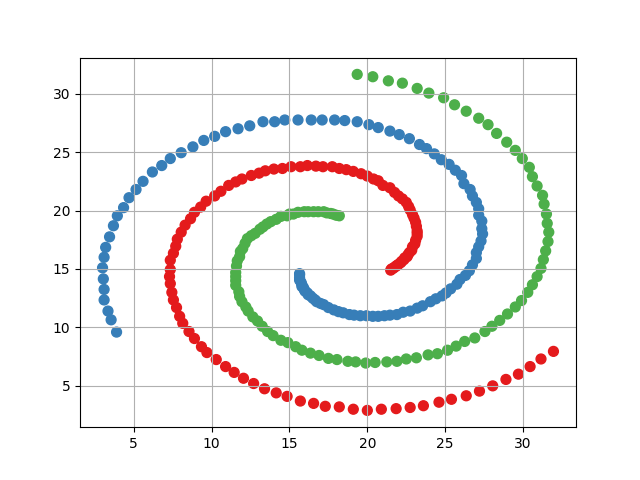

In [158]:
from sklearn.cluster import KMeans
from matplotlib import cm

kmeans10 = KMeans(n_clusters = 3)
clusters10 = kmeans10.fit_predict(U10)
cmap = cm.Set1.colors
color_to_clusters = {i : cmap[i] for i in range(4)}
color_array = np.array([color_to_clusters[cluster] for cluster in clusters10])
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
plt.grid()
plt.show()

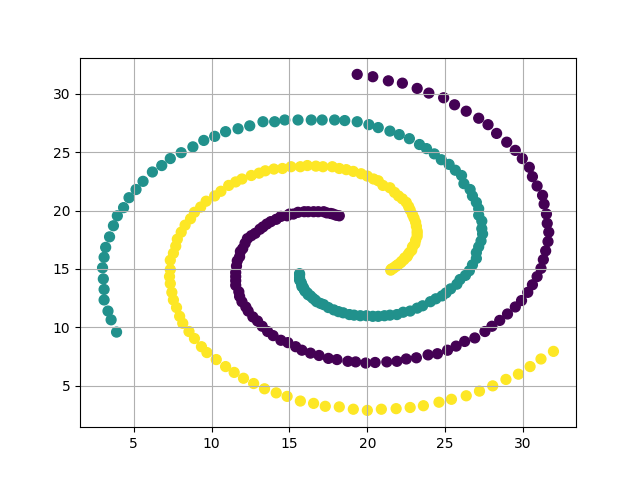

In [136]:
kmeans10_ = KMeans(n_clusters = 3)
testclusters10 = kmeans10_.fit_predict(testU10)
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = labels, s = 50)
plt.grid()

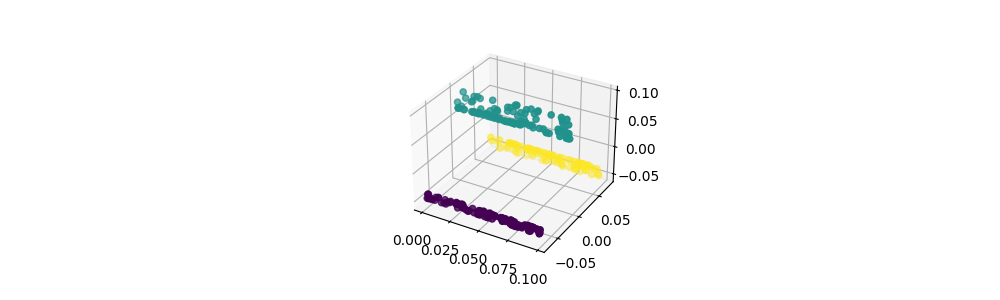

In [137]:
#Using eigenvectors from Shifting method
y20 = U20
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y20[:, 0], y20[:, 1], y20[:, 2], c= labels)
ax.grid()
plt.show()

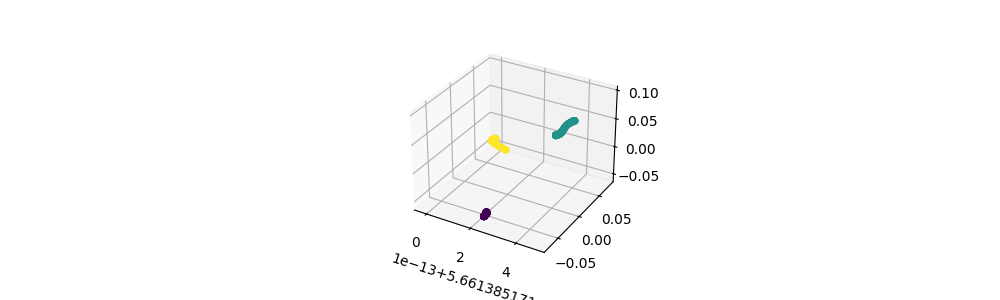

In [138]:
#Testing on TestU20 calculated with eigenvectors from eig method
y20= testU20
fig, ax = plt.subplots(1,figsize = (10,3), subplot_kw = {"projection" : "3d"})
ax.scatter(y20[:, 0], y20[:, 1], y20[:, 2], c= labels)
ax.grid()
plt.show()

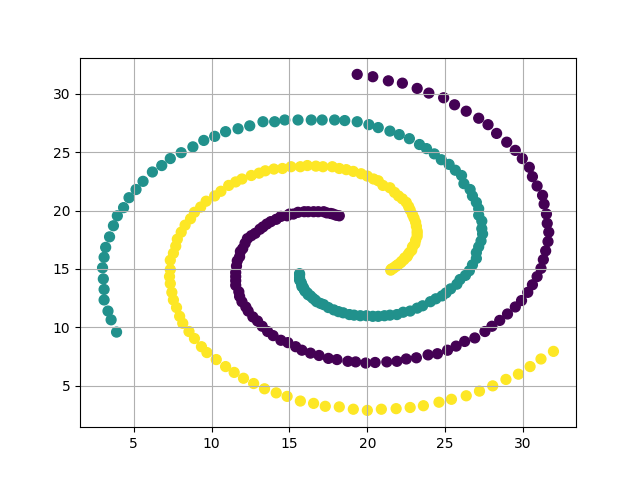

In [139]:
#Kmeans with shift
kmeans20 = KMeans(n_clusters = 3)
clusters20 = kmeans20.fit_predict(U20)
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = labels, s = 50)
plt.grid()
plt.show()

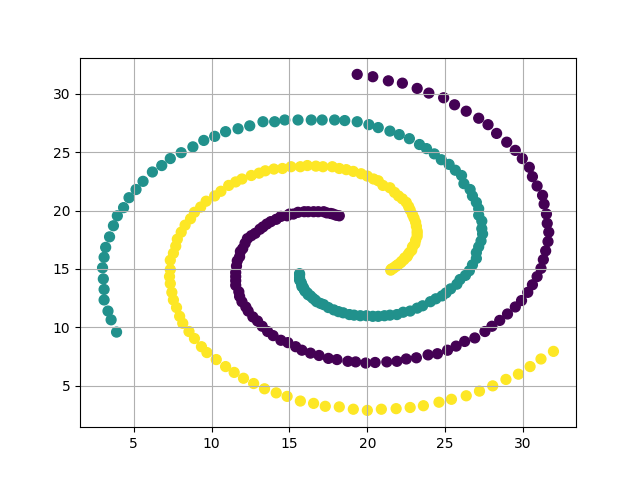

In [140]:
#Kmeans with eig
testkmeans20 = KMeans(n_clusters = 3)
testclusters20 = testkmeans20.fit_predict(testU20)
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = labels, s = 50)
plt.grid()
plt.show()

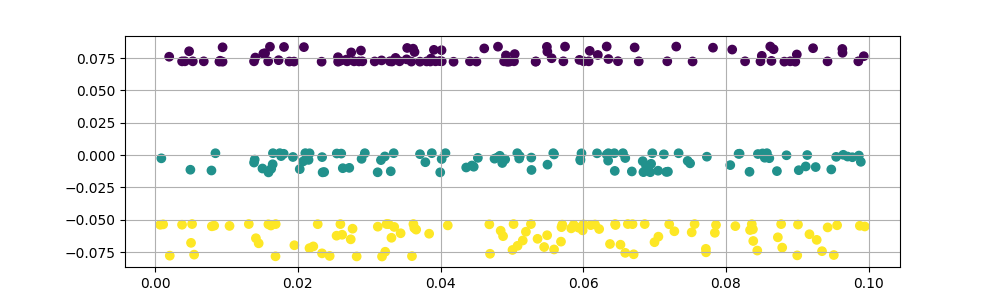

In [141]:
#Shift method
y40 = U40
plt.figure(figsize = (10,3))
plt.scatter(y40[:, 0], y40[:, 1], c= labels)
plt.grid()
plt.show()

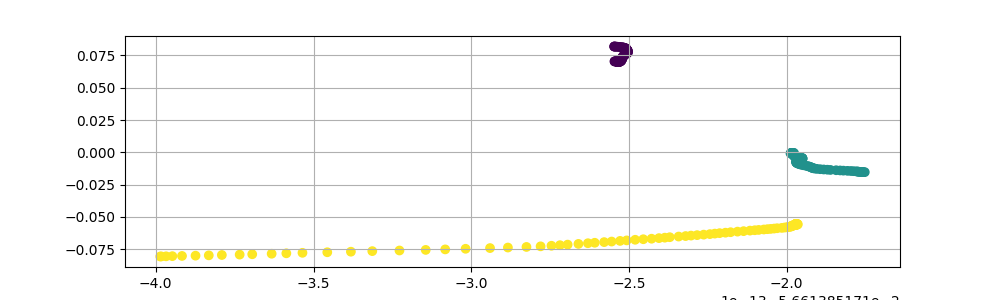

In [142]:
#eig method
y40 = testU40
plt.figure(figsize = (10,3))
plt.scatter(y40[:, 0], y40[:, 1], c= labels)
plt.grid()
plt.show()

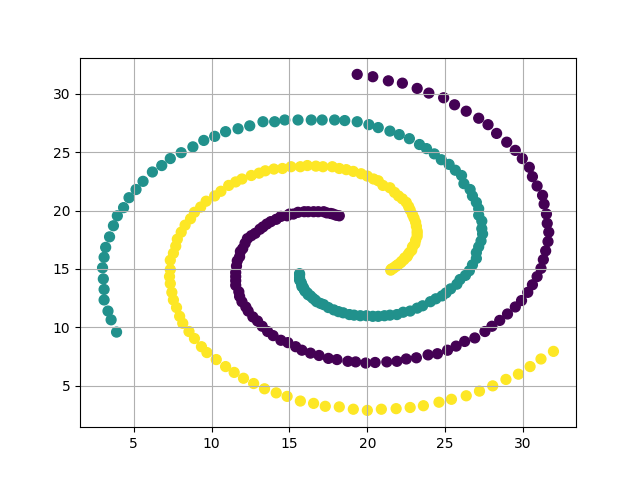

In [143]:
#Shift Method
kmeans40 = KMeans(n_clusters = 3)
clusters40 = kmeans40.fit_predict(U40)
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = labels, s = 50)
plt.grid()
plt.show()

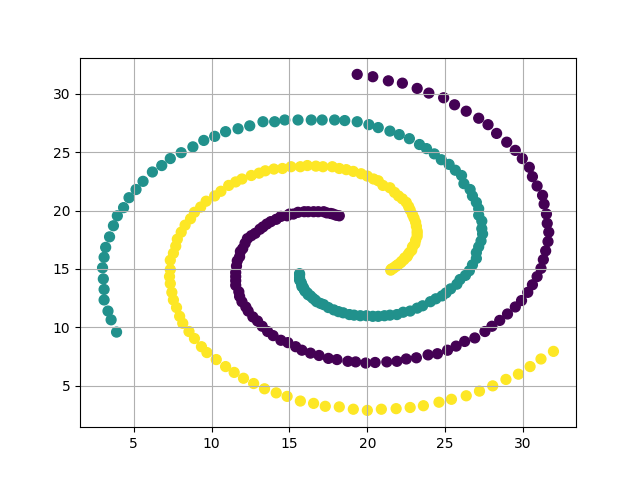

In [144]:
#eig Method
testkmeans40 = KMeans(n_clusters = 3)
testclusters40 = testkmeans40.fit_predict(testU40)
plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = labels, s = 50)
plt.grid()
plt.show()

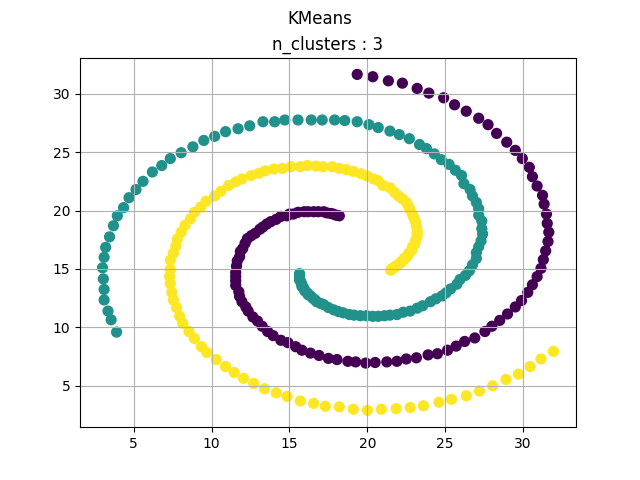

In [145]:
# K-means
k= 3 
kmeans = KMeans(n_clusters = 3)
testclusters_kmeans = kmeans.fit_predict(df.values)

plt.figure()
plt.scatter(df.values[:, 0], df.values[:, 1], c = labels, s = 50)
plt.title(f"n_clusters : {3}")
plt.grid()
plt.suptitle("KMeans")
plt.show()

In [151]:
#COMPARISON WITH SPECTRAL CLUSTERING (KMeans)

from sklearn.metrics import silhouette_score

for (name, clusters) in ([("Spect-Clustering 10-th", clusters10), ("Spect-Clustering 20-th",clusters20), ("Spect-Clustering 40-th",clusters40)]):
    personal_score = silhouette_score(df.values, clusters)
    kmeans = KMeans(n_clusters = 3)
    testclusters_kmeans = kmeans.fit_predict(df.values)
    kmeans_score = silhouette_score(df.values, testclusters_kmeans)
    print(f"{name} Score: {personal_score}, K-Means {3} clusters Score: {kmeans_score}")

Spect-Clustering 10-th Score: 0.008339684452069665, K-Means 3 clusters Score: 0.3577629618625443
Spect-Clustering 20-th Score: 0.008339684452069665, K-Means 3 clusters Score: 0.3577629618625443
Spect-Clustering 40-th Score: 0.008339684452069665, K-Means 3 clusters Score: 0.3577629618625443


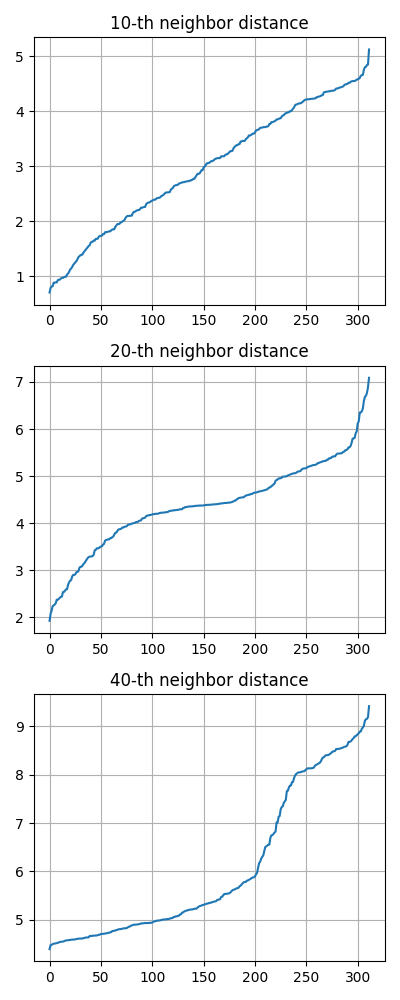

In [152]:
#OTHER CLUSTERING TECHNIQUES (DBScan)
from sklearn.cluster import DBSCAN

distances =  np.sort(euclidean_distances(df.values), axis = 1)
k_th_neighbors = [10, 20, 40]
fig, ax = plt.subplots(len(k_th_neighbors), 1, figsize = (4, 10))

for i, k in enumerate(k_th_neighbors):
    ax[i].plot(np.arange(distances.shape[0]), np.sort(distances[:, k]))
    ax[i].grid()
    ax[i].set_title(f"{k}-th neighbor distance")
plt.tight_layout()
plt.show()

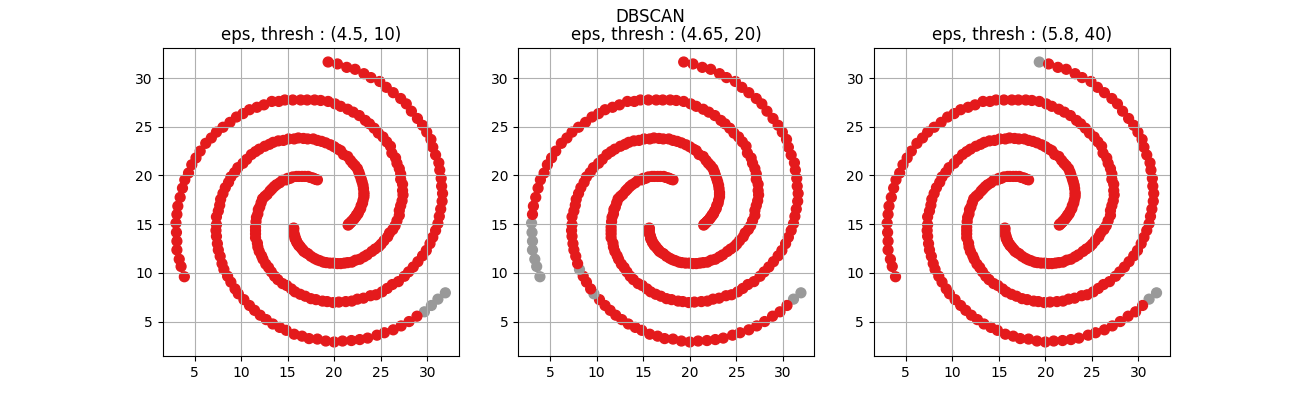

In [156]:
eps_ = [4.5, 4.65, 5.8]
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
for i, (eps, thresh) in enumerate(zip(eps_, k_th_neighbors)):
    dbscan = DBSCAN(eps = eps, min_samples = thresh)
    testclusters_dbscan = dbscan.fit_predict(df.values)
    cmap = cm.Set1.colors
    color_to_clusters = {i : cmap[i] for i in np.unique(testclusters_dbscan)}
    color_array = np.array([color_to_clusters[cluster] for cluster in testclusters_dbscan])
    ax[i].scatter(df.values[:, 0], df.values[:, 1], c = color_array, s = 50)
    ax[i].grid()
    ax[i].set_title(f"eps, thresh : {eps, thresh}")
fig.suptitle("DBSCAN")
plt.show()

In [157]:
for i, (name, clusters) in enumerate([("Spect-Clustering 10-th", clusters10), ("Spect-Clustering 20-th",clusters20), ("Spect-Clustering 40-th",clusters40)]):
    personal_score = silhouette_score(df.values, clusters)
    thresh = k_th_neighbors[i]
    eps = eps_[i]
    dbscan = DBSCAN(min_samples = thresh, eps = eps)
    testclusters_dbscan = dbscan.fit_predict(df.values)
    dbscan_score = silhouette_score(df.values, testclusters_dbscan)
    print(f"{name} Score: {personal_score}, DBScan thresh : {thresh} clusters Score: {dbscan_score}")

Spect-Clustering 10-th Score: 0.008339684452069665, DBScan thresh : 10 clusters Score: 0.20861754611882846
Spect-Clustering 20-th Score: 0.008339684452069665, DBScan thresh : 20 clusters Score: 0.22924735295131227
Spect-Clustering 40-th Score: 0.008339684452069665, DBScan thresh : 40 clusters Score: 0.23833156397042166
